# QLearning Examples

Start by importing QLearning class and functions written in QLearning.py

In [192]:
from QLearning import *
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

## First example - Painless QLearning tuto

First thing to do is to create the model of the system.
This is for simulation purpose, in real life it could be given by sensors.
The _model_ is given by the state graph and correspond to the possibility of performing an action (columns) from a given state (rows). For further explanations on this example, read [Painless QLearning tutorial](http://mnemstudio.org/path-finding-q-learning-tutorial.htm).

This function returns next state from a given state and action. The result of this action will be, by definition of the problem, to move to the room which number is the action provided if this action is feasible. Otherwise the robot stays in his state.

In [193]:
def apply_model(state, action):

    model = np.array([[0, 0, 0, 0, 1, 0], 
                      [0, 0, 0, 0, 0, 1], 
                      [0, 0, 0, 1, 0, 0], 
                      [0, 0, 1, 0, 1, 0], 
                      [1, 0, 0, 1, 0, 1], 
                      [0, 1, 0, 0, 1, 1]])
    
    if model[state, action]:
        
        return action
    
    else:
    
        return state

Define the starting and goal states and the reward of any action performed in any state.

In [194]:
R0 = np.array([[0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 100],
               [0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 100],
               [0, 0, 0, 0, 0, 100]])

state = 2
goal = 5

Create the QLearning object by providing the states and action lists, reward matrix, learning rate and discount factor.

In [195]:
learning = QLearning(range(0,6), range(0,6), R0, 0.5, 0.9)

First we need a training function.

In [196]:
def train_model(learning, start, steps, goal = -1, randomize = 0.5):
    '''
    goal_reached is set to -1 if we want to perform simulation exactly for the specified number of steps
    otherwise the value is the state goal and the simulation stops if it is reached 
    '''
    curr_state = start
    states_log = [curr_state]
    for i in range(steps):
        if curr_state != goal:
            action = learning.choose_action(state, randomize)
            next_state = apply_model(curr_state, action)
            learning.update_model(curr_state, action, next_state)
            curr_state = next_state
            states_log.append(curr_state)
        else:
            break
            
    return  states_log

We can perform a training until the robot reach the goal and visualize the path of the robot.

In [197]:
print(train_model(learning, state, 100, goal, 0))

[2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4, 5]


The effect on Q matrix can be verified:

In [198]:
print(learning.Q)

[[  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.  50.]
 [  0.   0.   0.   0.   0.   0.]]


Let's train the model 100 simulation of 20 steps by complete semi-random exploration. We do not stop the simulation if the goal is reached. That way we completely explore the world.

In [199]:
for i in range(100):
    path = train_model(learning, state, 20, -1, 0.5)
    if np.mod(i, 100) == 0:
        print(path)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2]


We can now check the Q matrix. For better visualization, we can show it with color scales.

[[ 533.  527.  547.  546.  622.  553.]
 [ 328.  322.  126.  442.  355.  595.]
 [ 497.  500.  500.  565.  496.  497.]
 [ 557.  563.  500.  554.  638.  563.]
 [ 546.  625.  625.  550.  631.  724.]
 [ 607.  498.  582.  566.  625.  703.]]


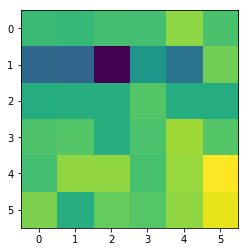

In [200]:
Q = np.round(learning.Q)
print(Q)
plt.imshow(Q)

We can check that the resulting policy allows to find a direct path to the goal.

In [201]:
def planer(learning, start, goal):
    curr_state = start
    path = [curr_state]
    i = 0
    while (curr_state != goal) and i < 1000:
        action = learning.choose_best_action(curr_state)
        next_state = apply_model(curr_state, action)
        curr_state = next_state
        path.append(curr_state)
        i += 1
    return path

In [202]:
print(planer(learning, state, goal))

[2, 3, 4, 5]


## Secound example - Grid World Path Finding

In this example we will try to find a path linking 2 points avoiding randomly generated obstacles in a grid world where posiible actions are the 4-neighbourhood of the cell.

In [210]:
import numpy as np
from QLearning import *
import GridWorld as gw
import matplotlib.pylab as plt

Some functions are needed to manage easily the grid map.

In [211]:
def mapper(x, dim):
    
    return [x//dim[1], np.mod(x, dim[1])]

def unmapper(x, dim):
    
    return x[0] * dim[1] + x[1]

dim = [20, 20]
model = np.zeros(dim)
model[np.where(np.random.rand(dim[0], dim[1]) > 0.6)] = 1 

def find_free(model):
    
    free = np.where(model == 0)
    rand_pos = np.random.randint(len(free[0]))

    return unmapper([free[0][rand_pos], free[1][rand_pos]], dim)

As in last example, I define a model for the simulation, assuming edged are obstacles.

In [212]:
def apply_model(state, action):
    
    cord = mapper(state, dim)
    
    if (cord[0] == 0 and action == 1) or (cord[0] == dim[0] - 1 and action == 3) or (cord[1] == 0 and action == 2) or (cord[1] == dim[1] - 1 and action == 0):
        
        return state
    
    elif (action == 0 and model[cord[0], cord[1] + 1]) or (action == 1 and model[cord[0] - 1, cord[1]]) or (action == 2 and model[cord[0], cord[1] - 1]) or (action == 3 and model[cord[0] + 1, cord[1]]):
        
        return state
    
    else:   
        
        if action == 0:
            
            return unmapper([cord[0], cord[1] + 1], dim)
                           
        elif action == 1:
            
            return unmapper([cord[0] - 1, cord[1]], dim)
                           
        elif action == 2:
            
            return unmapper([cord[0], cord[1] - 1], dim)
                           
        else:
            
            return unmapper([cord[0] + 1, cord[1]], dim)

Define a reward function, a random goal.

In [213]:
R0 = np.zeros([dim[0] * dim[1], 4])
goal = find_free(model)
R0[goal, 0] = 100
s0 = goal
while np.sum(np.abs(s0 - goal)) < np.sum(dim) * 0.8:
    s0 = find_free(model)

Create the learning object

In [236]:
learning = QLearning(range(0,dim[0] * dim[1]), range(0,4), R0, 0.5, 0.99)

In [237]:
preview = np.zeros(dim)

for _ in range(500):
            
    state = s0
    
    for _ in range(500):
        
        action = learning.choose_action(state,0.5)
        next_state = apply_model(state, action)
        learning.update_model(state, action, next_state)        
        state = next_state
        
    s = s0
    
for _ in range(dim[0] * dim[1]):

    s = apply_model(s, learning.choose_best_action(s))
    preview[tuple(mapper(s, dim))] = 0.5

    if s == goal:
        break
        
preview[tuple(mapper(s0, dim))] = 1
preview[tuple(mapper(goal, dim))] = 1

We can now visualize Q matrix and the learned path.

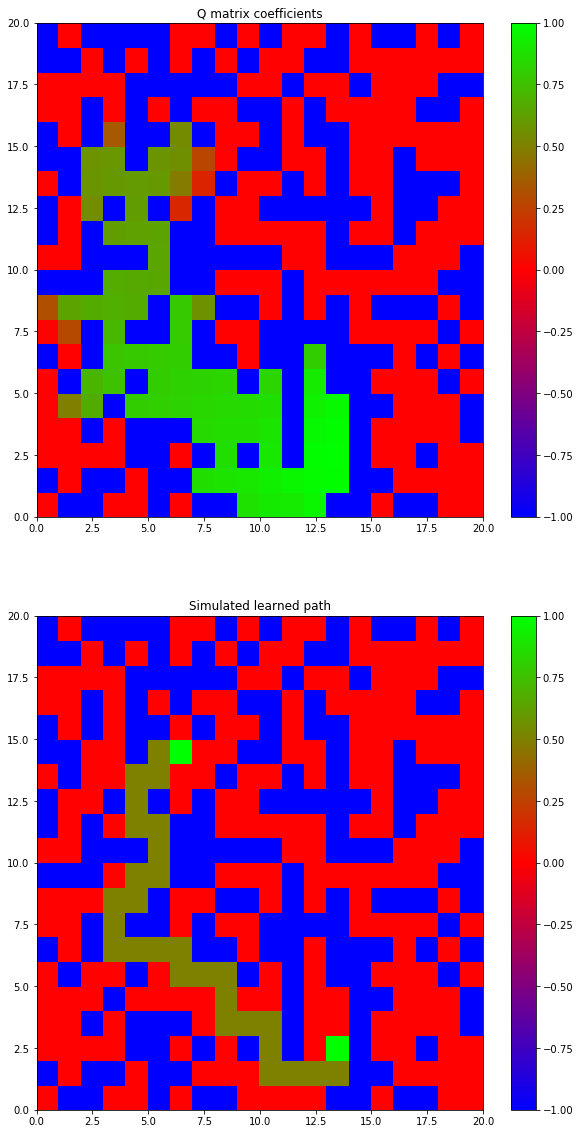

In [238]:
plt.figure(figsize=(dim[1]/2,dim[0]),facecolor='w') 
plt.clf()
plt.subplot(2, 1, 1)
plt.title('Q matrix coefficients')
gw.DrawMap(np.reshape(np.max(learning.Q, 1), dim), model)
plt.subplot(2, 1, 2)
plt.title('Simulated learned path')
gw.DrawMap(preview, model)
plt.pause(0.01)